In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import pyconll

from gensim.models import Word2Vec, FastText

from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger, SequentialBackoffTagger
from nltk.corpus import names
import nltk
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

## Задание 1

**Написать теггер на данных с руским языком**
1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбмнации  
2. написать свой теггер как на занятии, но улучшить попробовать разные векторайзеры, добавить знание не только букв и слов но и совместно объединить эти признаки  
3. вместо векторайзеров взять эмбединги попробовать (word2vec и fasttext по желанию дополнительно можно взять tf.keras.layers.Embedding)  
4. взять не только эмбединги каждого слова, но и взять соседей, т.е. информацию о соседях количество соседей выбрать самим (узнать наилучшее количество соседей)    
5. сравнить все реализованные методы сделать выводы

## загрузка данных

In [25]:
!pip install pyconll

In [26]:
import pyconll

In [27]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [28]:
!wget -O ./datasets/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
!wget -O ./datasets/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

--2021-04-12 17:42:29--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81043533 (77M) [text/plain]
Saving to: ‘./datasets/ru_syntagrus-ud-train.conllu’

./datasets/ru_synta 100%[===================>]  77.29M   103MB/s    in 0.7s    

2021-04-12 17:42:30 (103 MB/s) - ‘./datasets/ru_syntagrus-ud-train.conllu’ saved [81043533/81043533]

--2021-04-12 17:42:30--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercont

In [29]:
full_train = pyconll.load_from_file('datasets/ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('datasets/ru_syntagrus-ud-dev.conllu')

In [30]:
def convert_data(dataset):
    result = []

    for sent in dataset:
        for token in sent:
            result.append((token.form.lower(), token.upos))
            
    return result

In [31]:
train_data = convert_data(full_train) 
train_data[:5]

[('анкета', 'NOUN'),
 ('.', 'PUNCT'),
 ('начальник', 'NOUN'),
 ('областного', 'ADJ'),
 ('управления', 'NOUN')]

In [32]:
test_data = convert_data(full_test) 
test_data[:5]

[('алгоритм', 'NOUN'),
 (',', 'PUNCT'),
 ('от', 'ADP'),
 ('имени', 'NOUN'),
 ('учёного', 'NOUN')]

1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбинации


In [33]:
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

In [41]:
df_score = pd.DataFrame(columns=['values', 'UnigramTagger', 'BigramTagger', 'TrigramTagger', 'bi_unigram_tagger', 'tri_bigram_tagger','tri_bi_unigram_tagger']).set_index('values')
COUNT = (1000, 2000, 4000, 6000, 8000, 12000, 14000, 30000)

for C in COUNT:
    unigram_tagger = UnigramTagger([train_data[:C]])
    bigram_tagger = BigramTagger([train_data[:C]])
    trigram_tagger = TrigramTagger([train_data[:C]])
    bi_unigram_tagger = BigramTagger([train_data[:C]], backoff=unigram_tagger)
    tri_bigram_tagger = TrigramTagger([train_data[:C]], backoff=bigram_tagger)
    tri_bi_unigram_tagger = TrigramTagger([train_data[:C]], backoff=bi_unigram_tagger)

    df_score.loc[C, 'UnigramTagger'] = unigram_tagger.evaluate([test_data])
    df_score.loc[C, 'BigramTagger'] = bigram_tagger.evaluate([test_data])
    df_score.loc[C, 'TrigramTagger'] = trigram_tagger.evaluate([test_data])
    df_score.loc[C, 'bi_unigram_tagger'] = bi_unigram_tagger.evaluate([test_data])
    df_score.loc[C, 'tri_bigram_tagger'] = tri_bigram_tagger.evaluate([test_data])
    df_score.loc[C, 'tri_bi_unigram_tagger'] = tri_bi_unigram_tagger.evaluate([test_data])

df_score
    

,UnigramTagger,BigramTagger,TrigramTagger,bi_unigram_tagger,tri_bigram_tagger,tri_bi_unigram_tagger
values,,,,,,
1000,0.399951,0.00174401,0.00171873,0.401139,0.00174401,0.401164
2000,0.449963,0.00174401,0.00171873,0.451235,0.00174401,0.451429
4000,0.489064,0.00174401,0.00171873,0.490935,0.00174401,0.491111
6000,0.516741,0.00198834,0.00171873,0.51728,0.00198834,0.517356
8000,0.525351,0.00722879,0.00171873,0.527281,0.00723722,0.52739
12000,0.548243,0.0401206,0.00171873,0.549843,0.0401459,0.550113
14000,0.565084,0.080157,0.00171873,0.567755,0.079997,0.568
30000,0.643573,0.118449,0.00171873,0.635477,0.118424,0.635957


Лучшие результаты получились у моделей, где использован UnigramTagger. При этом комбинации лучше, но ненамного. TrigramTagger справляется хуже всего, но позволяет чуть-чуть улучшить сочетание Bi и Uni в последнем варианте. 

2. написать свой теггер как на занятии, но улучшить попробовать разные векторайзеры, добавить знание не только букв и слов но и совместно объединить эти признаки

In [46]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])
    
fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])
    
fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [48]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [50]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)

In [51]:
test_enc_labels = le.transform(test_label)

In [52]:
le.classes_

array(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NO_TAG', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM',
       'VERB', 'X'], dtype='<U6')

In [53]:
hvectorizer = HashingVectorizer(ngram_range=(1, 5), analyzer='char', n_features=100)

In [54]:
X_train = hvectorizer.fit_transform(train_tok)

In [55]:
X_test = hvectorizer.transform(test_tok)

In [56]:
X_train.shape

(871526, 100)

In [57]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, train_enc_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
pred = lr.predict(X_test)

In [59]:
accuracy_score(test_enc_labels, pred)

0.685454790550332

In [74]:
cvectorizer = CountVectorizer(ngram_range=(1, 5), analyzer='char', max_features=100)
Xc_train = cvectorizer.fit_transform(train_tok)
Xc_test = cvectorizer.transform(test_tok)

In [75]:
lr = LogisticRegression(random_state=0)
lr.fit(Xc_train, train_enc_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
pred_c = lr.predict(Xc_test)

In [77]:
accuracy_score(test_enc_labels, pred_c)

0.7769689616823375

In [66]:
hvectorizer = HashingVectorizer(ngram_range=(1, 5), analyzer='word', n_features=100)
Xhw_train = hvectorizer.fit_transform(train_tok)
Xhw_test = hvectorizer.transform(test_tok)

In [67]:
lr = LogisticRegression(random_state=0)
lr.fit(Xhw_train, train_enc_labels)
pred_hw = lr.predict(Xhw_test)
accuracy_score(test_enc_labels, pred_hw)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.288326087689145

In [73]:
cvectorizer = CountVectorizer(ngram_range=(1, 5), analyzer='word', max_features=100)
Xcw_train = cvectorizer.fit_transform(train_tok)
Xcw_test = cvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0)
lr.fit(Xcw_train, train_enc_labels)
pred_cw = lr.predict(Xcw_test)
accuracy_score(test_enc_labels, pred_cw)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.382081353418933

In [68]:
hvectorizer = HashingVectorizer(ngram_range=(1, 5), analyzer='char_wb', n_features=100)
Xhcw_train = hvectorizer.fit_transform(train_tok)
Xhcw_test = hvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0)
lr.fit(Xhcw_train, train_enc_labels)
pred_hcw = lr.predict(Xhcw_test)
accuracy_score(test_enc_labels, pred_hcw)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7333265931992047

In [72]:
cvectorizer = CountVectorizer(ngram_range=(1, 5), analyzer='char_wb', max_features=100)
Xccw_train = cvectorizer.fit_transform(train_tok)
Xccw_test = cvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0)
lr.fit(Xccw_train, train_enc_labels)
pred_ccw = lr.predict(Xccw_test)
accuracy_score(test_enc_labels, pred_ccw)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7749806221143801

3. вместо векторайзеров взять эмбединги попробовать (word2vec и fasttext по желанию дополнительно можно взять tf.keras.layers.Embedding)


4. взять не только эмбединги каждого слова, но и взять соседей, т.е. информацию о соседях количество соседей выбрать самим (узнать наилучшее количество соседей)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/pytho

,CastomTagger
vectorizer,
W2V 3,0.414257
FT 3,0.364102
W2V 5,0.412926
FT 5,0.365838
W2V 9,0.419
FT 9,0.369073
W2V 15,0.424797
FT 15,0.372999


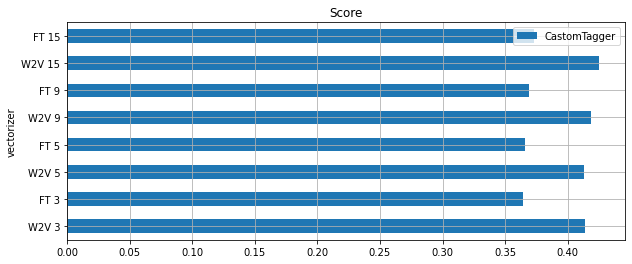

In [89]:
df_score_vec = pd.DataFrame(columns=['vectorizer', 'Tagger']).set_index('vectorizer')

for window in (3, 5, 9, 15):
  for emb_key, emd_val in {'W2V': Word2Vec(sentences=[train_tok[:2000] + test_tok], size=300, window=window, min_count=1), 
                           'FT': FastText(sentences=[train_tok[:2000] + test_tok], size=300, window=window, min_count=1)}.items():

    X_train = np.array([emd_val[word] for word in train_tok[:2000]])
    X_test = np.array([emd_val[word] for word in test_tok])

    lr = LogisticRegression()
    lr.fit(X_train, train_enc_labels[:2000])
    y_pred = lr.predict(X_test)

    df_score_vec.loc[f'{emb_key} {window}', 'Tagger'] = accuracy_score(test_enc_labels, y_pred)

df_score_vec.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
df_score_vec

5. сравнить все реализованные методы сделать выводы


Лучше всех показал себя Countvectorizer по буквам. Результаты с эмбеддингами сравнительно похожи на лучшие результаты UnigramTagger и его комбинации, но уступают. 

# Задание 2

много дополнительных датасетов на русском языке

https://natasha.github.io/corus/  
https://github.com/natasha/corus

мы будем использовать данные http://ai-center.botik.ru/Airec/index.php/ru/collections/28-persons-1000

**Проверить насколько хорошо работает NER**

1. взять нер из nltk
2. проверить deeppavlov
3. написать свой нер попробовать разные подходы (с доп информацией без) так же с учётом соседей и без них
4. сделать выводы по вашим экспериментам какой из подходов успешнее справляется

при обучении своего нера незабудьте разделить выборку

In [90]:
!pip install corus

     |████████████████████████████████| 92kB 3.2MB/s 


In [91]:
import corus

In [92]:
!wget http://ai-center.botik.ru/Airec/ai-resources/Persons-1000.zip

--2021-04-12 20:42:19--  http://ai-center.botik.ru/Airec/ai-resources/Persons-1000.zip
Resolving ai-center.botik.ru (ai-center.botik.ru)... 95.129.138.2
Connecting to ai-center.botik.ru (ai-center.botik.ru)|95.129.138.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3363777 (3.2M) [application/zip]
Saving to: ‘Persons-1000.zip’

Persons-1000.zip    100%[===================>]   3.21M  2.75MB/s    in 1.2s    

2021-04-12 20:42:21 (2.75 MB/s) - ‘Persons-1000.zip’ saved [3363777/3363777]



In [93]:
!ls

datasets  Persons-1000.zip  sample_data


In [94]:
path = 'Persons-1000.zip'
records = corus.persons.load_persons(path)
rec = next(records)

In [95]:
rec

PersonsMarkup(
    text='Россия рассчитывает на конструктивное воздействие США на Грузию\r\n\r\n04/08/2008 12:08\r\n\r\nМОСКВА, 4 авг - РИА Новости. Россия рассчитывает, что США воздействуют на Тбилиси в связи с обострением ситуации в зоне грузино-осетинского конфликта. Об этом статс-секретарь - заместитель министра иностранных дел России Григорий Карасин заявил в телефонном разговоре с заместителем госсекретаря США Дэниэлом Фридом.\r\n\r\n"С российской стороны выражена глубокая озабоченность в связи с новым витком напряженности вокруг Южной Осетии, противозаконными действиями грузинской стороны по наращиванию своих вооруженных сил в регионе, бесконтрольным строительством фортификационных сооружений", - говорится в сообщении.\r\n\r\n"Россия уже призвала Тбилиси к ответственной линии и рассчитывает также на конструктивное воздействие со стороны Вашингтона", - сообщил МИД России. ',
    spans=[PersonsSpan(
         id=1,
         start=308,
         stop=324,
         value='ГРИГОРИЙ КАР

In [96]:
print(rec.text)

Россия рассчитывает на конструктивное воздействие США на Грузию

04/08/2008 12:08

МОСКВА, 4 авг - РИА Новости. Россия рассчитывает, что США воздействуют на Тбилиси в связи с обострением ситуации в зоне грузино-осетинского конфликта. Об этом статс-секретарь - заместитель министра иностранных дел России Григорий Карасин заявил в телефонном разговоре с заместителем госсекретаря США Дэниэлом Фридом.

"С российской стороны выражена глубокая озабоченность в связи с новым витком напряженности вокруг Южной Осетии, противозаконными действиями грузинской стороны по наращиванию своих вооруженных сил в регионе, бесконтрольным строительством фортификационных сооружений", - говорится в сообщении.

"Россия уже призвала Тбилиси к ответственной линии и рассчитывает также на конструктивное воздействие со стороны Вашингтона", - сообщил МИД России. 


In [97]:
rec.spans

[PersonsSpan(
     id=1,
     start=308,
     stop=324,
     value='ГРИГОРИЙ КАРАСИН'
 ), PersonsSpan(
     id=2,
     start=387,
     stop=402,
     value='ДЭНИЭЛ ФРИД'
 )]

In [98]:
!pip install razdel

In [99]:
from razdel import tokenize

In [100]:
records = corus.persons.load_persons(path)
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        is_person = False
        for person in rec.spans:
            if (token.start >= person.start) and (token.stop <= person.stop):
                is_person = True
                break
        words.append([token.text, 'PERSON' if is_person else 'NO_PERSON'])
    words_docs.extend(words)

теперь у нас есть слово и тег персона или нет, уже можно что-то делать(пробовать какие-то мл алгоритмы)  
*дополнительно попробуйте проанализировать все ли токены если рассматривать униграмный подход относятся к тегам персона с логической точки зрения

In [101]:
words_docs[:5]

[['Россия', 'NO_PERSON'],
 ['рассчитывает', 'NO_PERSON'],
 ['на', 'NO_PERSON'],
 ['конструктивное', 'NO_PERSON'],
 ['воздействие', 'NO_PERSON']]

1. взять нер из nltk

In [104]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [105]:
nltk.pos_tag(nltk.word_tokenize(rec.text))

[('Мать', 'JJ'),
 ('рядового', 'NNP'),
 ('Владислава', 'NNP'),
 ('Челаха', 'NNP'),
 (',', ','),
 ('обвиняемого', 'NNP'),
 ('в', 'NNP'),
 ('убийстве', 'VBD'),
 ('14', 'CD'),
 ('пограничников', 'NNP'),
 ('и', 'NNP'),
 ('егеря', 'NNP'),
 (',', ','),
 ('после', 'NNP'),
 ('свидания', 'NNP'),
 ('с', 'NNP'),
 ('сыном', 'NNP'),
 ('заметила', 'NNP'),
 ('следы', 'NNP'),
 ('побоев', 'NNP'),
 ('.', '.'),
 ('Как', 'VB'),
 ('передаёт', 'JJ'),
 ('РИА', 'NNP'),
 ('``', '``'),
 ('Новости', 'NN'),
 ("''", "''"),
 ('со', 'CC'),
 ('ссылкой', 'NNP'),
 ('на', 'NNP'),
 ('местную', 'NNP'),
 ('газету', 'NNP'),
 ('``', '``'),
 ('Время', 'NN'),
 ("''", "''"),
 (',', ','),
 ('Владислав', 'NNP'),
 ('Челах', 'NNP'),
 (',', ','),
 ('несший', 'NNP'),
 ('службу', 'NNP'),
 ('на', 'NNP'),
 ('пограничной', 'NNP'),
 ('заставе', 'NNP'),
 ('``', '``'),
 ('Арканкерген', 'NN'),
 ("''", "''"),
 ('в', 'CC'),
 ('Алма-Атинской', 'JJ'),
 ('области', 'NNP'),
 ('на', 'NNP'),
 ('границе', 'NNP'),
 ('с', 'NNP'),
 ('Китаем', 'NNP'),
 (

In [106]:
import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [107]:
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(rec.text))) if hasattr(chunk, 'label') }

{('Владислав Челах', 'PERSON'),
 ('Китаем', 'PERSON'),
 ('Кроме', 'PERSON'),
 ('Мать', 'PERSON'),
 ('Напомним', 'PERSON'),
 ('Пистолет', 'PERSON'),
 ('РИА', 'ORGANIZATION'),
 ('Челах', 'PERSON'),
 ('Челаха', 'PERSON'),
 ('Челаха BNews.kz', 'PERSON')}

Результат получился не очень, ошибочно отмечены слова, не относящиеся к персонам/организациям

2. проверить deeppavlov
3. написать свой нер попробовать разные подходы (с доп информацией без) так же с учётом соседей и без них
4. сделать выводы по вашим экспериментам какой из подходов успешнее справляется

In [1]:
# установка deeppavlov

!pip uninstall -y tensorflow tensorflow-gpu
!pip install numpy scipy librosa unidecode inflect librosa transformers
!pip install deeppavlov

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
  Using cached https://files.pythonhosted.org/packages/20/53/127cb49435bcf5d841baf8eafa030931c62a9eac577a641f8c2293d23371/numpy-1.18.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.25.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstal

In [2]:
!python -m deeppavlov install squad_bert
!python -m deeppavlov install ner_ontonotes

2021-04-12 22:28:59.273 INFO in 'deeppavlov.core.common.file'['file'] at line 32: Interpreting 'squad_bert' as '/usr/local/lib/python3.7/dist-packages/deeppavlov/configs/squad/squad_bert.json'
  Cloning https://github.com/deepmipt/bert.git (to revision feat/multi_gpu) to /tmp/pip-req-build-2lisruyz
  Running command git clone -q https://github.com/deepmipt/bert.git /tmp/pip-req-build-2lisruyz
  Created wheel for bert-dp: filename=bert_dp-1.0-cp37-none-any.whl size=23581 sha256=b75924332f30a5056682e13626c2bb5fbdeeb0bb8c99ebf0f843bbd866e7a83c
  Stored in directory: /tmp/pip-ephem-wheel-cache-f21m1ge0/wheels/1e/41/94/886107eaf932532594886fd8bfc9cb9d4db632e94add49d326
Successfully built bert-dp
  Using cached https://files.pythonhosted.org/packages/5b/81/84fb7a323f9723f81edfc796d89e89aa95a9446ed7353c144195b3a3a3ba/tensorflow-1.15.2-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1e/e9/d3d747a97f7188f48aa5eda486907f3b345cd409f0a0850468ba867db246/te

In [3]:
import deeppavlov
from deeppavlov import configs, build_model



In [4]:
!pip install --upgrade tensorflow
import tensorflow as tf
print(tf.__version__)

  Using cached https://files.pythonhosted.org/packages/70/dc/e8c5e7983866fa4ef3fd619faa35f660b95b01a2ab62b3884f038ccab542/tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/08/d6/a6aaa29fea945bc6c61d11f6e0697b325ff7446de5ffd62c2fa02f627048/numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/64/21/eebd23060763fedeefb78bc2b286e00fa1d8abda6f70efa2ee08c28af0d4/tensorboard-2.4.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/74/7e/622d9849abf3afb81e482ffc170758742e392ee129ce1540611199a59237/tensorflow_estimator-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d6/84/759f5dd23fec8ba71952d97bcc7e2c9d7d63bdc582421f3cd4be845f0c98/gast-0.3.3-py2.py3-none-any.whl
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirem

2.4.1


In [5]:
deeppavlov_ner = build_model(configs.ner.ner_bert_ent_and_type_rus, download=True)
rus_document = "Нью-Йорк, США, 30 апреля 2020, 01:01 — REGNUM В администрации президента США Дональда Трампа планируют пройти все этапы создания вакцины от коронавируса в ускоренном темпе и выпустить 100 млн доз до конца 2020 года, передаёт агентство Bloomberg со ссылкой на осведомлённые источники"
deeppavlov_ner([rus_document])

2021-04-12 22:30:11.34 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/deeppavlov_data/bert/multi_cased_L-12_H-768_A-12.zip download because of matching hashes
2021-04-12 22:30:12.11 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/kbqa/datasets/entity_and_type_detection_rus.pickle download because of matching hashes
2021-04-12 22:30:15.882 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/kbqa/models/ner_cq_rus.tar.gz download because of matching hashes
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_d

AttributeError: ignored

К сожалению, никак не смог запустить deeppavlov, пробовал разные версии tf..